# Travelling Salesman Problem - Genetic Algorithm Approach

## Imports 

In [31]:
from matplotlib import pyplot as plt
import random

from deap import creator
from deap import tools
from deap import algorithms
from deap import base
import numpy as np
import time
from shapely.geometry import Point  #conda install -c conda-forge shapely

random.seed(123)

## Options

In [32]:
# City Options
NUM_CITIES = 15
MAX_X = 100
MAX_Y = 100

# Algorithm Options
POPULATION_SIZE = 300
MUTATION_RATIO = 0.1
CROSSOVER_RATIO = 0.5
NGEN = 40

## Generate Cities

In [49]:
# Generate Random Cities
cities = []
for i in range(NUM_CITIES):
    cities.append(Point(random.randint(0, 100), random.randint(0, 100)))
    print(cities[i-1])

POINT (59 55)
POINT (59 55)
POINT (71 63)
POINT (79 66)
POINT (20 49)
POINT (0 92)
POINT (27 84)
POINT (15 33)
POINT (7 62)
POINT (2 41)
POINT (94 73)
POINT (67 12)
POINT (66 91)
POINT (91 0)
POINT (79 0)


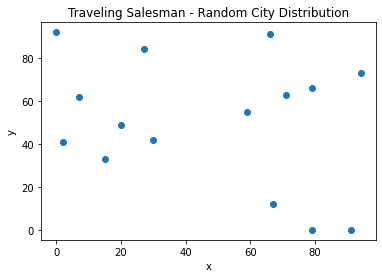

In [50]:
# Visualize Cities
plt.scatter([c.x for c in cities], [c.y for c in cities])

plt.xlabel("x")
plt.ylabel("y")

plt.title("Traveling Salesman - Random City Distribution")
plt.savefig("salesman.png")

## Define Initialization, Fitness Function, Mating and Mutation

In [66]:
# Chromosome initialization: Random order of town indices
def ini_salesman(container, num_cities):
    basic_plan = list(range(num_cities))
    print(basic_plan)
    random.shuffle(basic_plan) #洗牌
    return container(basic_plan)

In [67]:
test = ini_salesman(list, 10)
print(test)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[3, 4, 2, 7, 6, 0, 5, 1, 9, 8]


In [53]:
# Fitness Function: Total path length
def calc_distance(travel_plan, cities):
    dist = 0
    for i, e in enumerate(travel_plan):
        if i!= len(cities)-1:
            origin = cities[e]
            destination = cities[travel_plan[i+1]]
        else:
            # Return home
            origin = cities[e]
            destination = cities[travel_plan[0]]
        dist += origin.distance(destination)
    return dist,

In [54]:
# Mutation: Switch two random positions of the travel plan
def mutate_travel_plan(travel_plan):
    
    # Determine indices to be switched
    idx_1 = random.choice(list(range(len(travel_plan))))
    idx_2 = random.choice(list(range(len(travel_plan))))
    
    # Switch indices
    travel_plan[idx_1], travel_plan[idx_2] = travel_plan[idx_2], travel_plan[idx_1]
    
    return travel_plan,

In [55]:
# Mating two travel plans to generate one child: Retain x consecutive city ids of tp_1 and fill with tp_2 order
# Example:
# tp_1: [0,1,2,3,4,5]
# tp_2: [3,2,1,5,0,4]
# Retain: [1,2,3]
# Child: [5,1,2,3,0,4]
def mate_travel_plans_single(tp_1, tp_2):
    
    N = len(tp_1)
    
    idx_1 = random.choice(list(range(N)))
    idx_2 = random.choice(list(range(N)))
    
    idx_start = min(idx_1, idx_2)
    idx_stop = max(idx_1, idx_2)
    
    if idx_start==idx_stop:
        if idx_start > 0:
            idx_start = idx_start-1
        else:
            idx_stop = idx_stop+1
    
    retain_sequence = tp_1[idx_start:idx_stop+1]
    substitute_values = [i for i in tp_2 if i not in retain_sequence]
    substitute_places = [i for i in list(range(N)) if i<idx_start or i>idx_stop]
    
    for i in substitute_places:
        tp_1[i] = substitute_values.pop(0)
    
    return tp_1

In [56]:
# Test function
mate_travel_plans_single([0,1,2,3,4,5], [3,2,1,5,0,4])

[2, 1, 0, 3, 4, 5]

In [57]:
def mate_travel_plans(tp_1, tp_2):
    ind1 = mate_travel_plans_single(tp_1, tp_2)
    ind2 = mate_travel_plans_single(tp_1, tp_2)
    return ind1, ind2

## Build GA Model

In [58]:
# Define classes
# Create a class "total_distance". Define it as a fitness. Fitness shall be minimized (-1)
#creator.create("total_distance", base.Fitness, weights=(-1.0,))
creator.create( "FitnessMin", base.Fitness, weights=( -1.0, ) )
# Create a class "Individual" containing a list and assign a fitness of type "travel_distance"
#creator.create("Individual", list, fitness=creator.total_distance) 
creator.create( "Individual", list, fitness = creator.FitnessMin )

# Open a new toolbox
toolbox = base.Toolbox()

# Register an "individual" to be of class "Individual". Initialize it with the ini_salesman function. Pass necessary values
toolbox.register("individual", ini_salesman, creator.Individual, num_cities=NUM_CITIES)

# Register a "population" and initialize it with a list of "individual" objects
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register a fitness function called "travel_distance" and assign an evaluation function (calc_distance) to it
toolbox.register("travel_distance", calc_distance, cities=cities)

# Register functions for mating, mutating and selecting
toolbox.register("mate", mate_travel_plans) #交配
toolbox.register("mutate", mutate_travel_plan) #突變
#toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.01)
toolbox.register("select", tools.selTournament, tournsize=10) # 选择保留的最佳个体

## Run GA

In [59]:
# Generate intial population
population = toolbox.population(n=POPULATION_SIZE)
#一開始需要確定群體的大小( Population Size )。就是每一次的染色體有多少個啦~
#例如我要透過50個染色體運算，所以我該次的群體大小就是50。

In [60]:
for gen in range(NGEN):
    print("Calculating generation {} of {}".format(gen+1,NGEN))
    
    # Retrieve all new offsprings generated by mutation and crossover (mating)
    # algorithms.varAnd进化算法的一部分，仅应用变化部分（交叉和变异）,克隆了个体，因此返回的种群独立于输入种群
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=MUTATION_RATIO) ##交叉变异
    #// cxpb = Crossover (交叉配對) 的比例
    #// mutpb = Mutation (突變) 的比例
    
    # For each individual in the toolbox that has not been evaluated before, evaluate the fitness
    fits = toolbox.map(toolbox.travel_distance, offspring)
    
    # Assign fitness values to individuals
    for fit, ind in zip(fits, offspring): #將資料「鏈」起來 n個列表合併成一個
        ind.fitness.values = fit
        
    # Create new population
    population = toolbox.select(offspring, k=len(population))

Calculating generation 1 of 40
Calculating generation 2 of 40
Calculating generation 3 of 40
Calculating generation 4 of 40
Calculating generation 5 of 40
Calculating generation 6 of 40
Calculating generation 7 of 40
Calculating generation 8 of 40
Calculating generation 9 of 40
Calculating generation 10 of 40
Calculating generation 11 of 40
Calculating generation 12 of 40
Calculating generation 13 of 40
Calculating generation 14 of 40
Calculating generation 15 of 40
Calculating generation 16 of 40
Calculating generation 17 of 40
Calculating generation 18 of 40
Calculating generation 19 of 40
Calculating generation 20 of 40
Calculating generation 21 of 40
Calculating generation 22 of 40
Calculating generation 23 of 40
Calculating generation 24 of 40
Calculating generation 25 of 40
Calculating generation 26 of 40
Calculating generation 27 of 40
Calculating generation 28 of 40
Calculating generation 29 of 40
Calculating generation 30 of 40
Calculating generation 31 of 40
Calculating gener

In [61]:
winner = tools.selBest(population, k=1)

In [62]:
winner

[[14, 3, 6, 8, 7, 4, 5, 11, 9, 2, 1, 0, 12, 13, 10]]

## Run GA

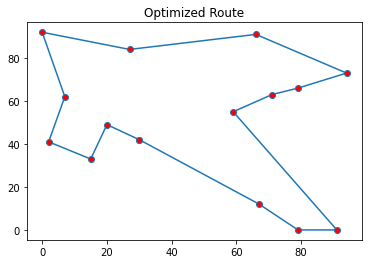

In [63]:
# Visualize Result
cities_ordered = [cities[e] for e in winner[0]]
X = [c.x for c in cities_ordered]+[cities_ordered[0].x]
Y = [c.y for c in cities_ordered]+[cities_ordered[0].y]
plt.plot(X,Y, marker = "o", markerfacecolor='red')
plt.title("Optimized Route")
plt.savefig("salesman_solution.png")